<a href="https://colab.research.google.com/github/manishbayesian/bayesianbookpub/blob/main/Chapter_2_Distributions_with_TFP.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Chapter 2 - Distributions with TensorFlow Probability

## Imports

In [ ]:
from IPython.display import HTML, display
 
def set_css():
  display(HTML('''
  <style>
    pre {
        white-space: pre-wrap;
    }
  </style>
  '''))
get_ipython().events.register('pre_run_cell', set_css)

In [ ]:
from scipy import special
import math
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from numpy import random
import numpy as np
import sys

sns.set_theme(style="darkgrid")
pd.set_option('display.precision', 3)
pd.set_option('display.float_format',  '{:,.3f}'.format)

## Install and import TFP packages

In [ ]:
import tensorflow as tf
import tensorflow_probability as tfp
try:
  tf.compat.v1.enable_eager_execution()
except ValueError:
  pass


In [ ]:
## what version are we using?
print('TFP Version', tfp.__version__)

TFP Version 0.16.0


## What all Distributions are available in TFP?

### List all distributions in PyMC

In [ ]:
display(tfp.distributions.__all__)

['Autoregressive',
 'BatchBroadcast',
 'BatchReshape',
 'Bates',
 'Bernoulli',
 'Beta',
 'BetaBinomial',
 'BetaQuotient',
 'Binomial',
 'Blockwise',
 'Categorical',
 'Cauchy',
 'Chi',
 'Chi2',
 'CholeskyLKJ',
 'DeterminantalPointProcess',
 'Deterministic',
 'Dirichlet',
 'DirichletMultinomial',
 'Distribution',
 'DoublesidedMaxwell',
 'Empirical',
 'ExpGamma',
 'ExpInverseGamma',
 'Exponential',
 'ExponentiallyModifiedGaussian',
 'ExpRelaxedOneHotCategorical',
 'FiniteDiscrete',
 'FULLY_REPARAMETERIZED',
 'Gamma',
 'GammaGamma',
 'GaussianProcess',
 'GaussianProcessRegressionModel',
 'GeneralizedExtremeValue',
 'GeneralizedNormal',
 'GeneralizedPareto',
 'Geometric',
 'Gumbel',
 'HalfCauchy',
 'HalfNormal',
 'HalfStudentT',
 'HiddenMarkovModel',
 'Horseshoe',
 'Independent',
 'independent_joint_distribution_from_structure',
 'InverseGamma',
 'InverseGaussian',
 'JohnsonSU',
 'JointDistribution',
 'JointDistributionCoroutine',
 'JointDistributionCoroutineAutoBatched',
 'JointDistributio

#### Code to display all distributions 'nicely'

In [ ]:
distrs = {}
for d in tfp.distributions.__all__:
  cls = getattr(sys.modules[tfp.distributions.__name__],d)
  cname = str(cls)
  if cname.startswith('<class'):
   # dtyp = cname.split("'")[1].split('.')[-2]
    desc = ''
    if cls.__doc__:
      desc = list(filter(lambda x: len(x) > 0, cls.__doc__.split('\n')))[0].strip()
    distrs[d] = {'description':desc}

In [ ]:
pd.DataFrame.from_dict(distrs,orient='index')

,description
Autoregressive,Autoregressive distributions.
BatchBroadcast,A distribution that broadcasts an underlying d...
BatchReshape,The Batch-Reshaping distribution.
Bates,Bates distribution.
Bernoulli,Bernoulli distribution.
...,...
VonMisesFisher,The von Mises-Fisher distribution over unit ve...
Weibull,The Weibull distribution with 'concentration' ...
WishartLinearOperator,The matrix Wishart distribution on positive de...
WishartTriL,The matrix Wishart distribution parameterized ...


## Functions for Plotting Distributions & Likelihoods

In [ ]:
def plot_disc(rv, dname = '', ax=None):
    """
    Plot discrete distribution
    """
    if ax is None:
        _, ax = plt.subplots(figsize=(3,3))
    samples = rv.sample(1000)
    x = np.unique(samples)
    y=np.exp(rv.log_prob(x))
    ax.stem(x,y,markerfmt='C0o',use_line_collection=True,linefmt='C0-',basefmt=" ") 
    ax.set_xlim([min(x)-0.5,max(x)+0.5])
    #ax.set_ylim([0,1])
    ax.set_xticks(x)
   # ax.set_yticklabels(ax.get_yticklabels(),fontsize='small')
    ax.tick_params(axis='y', labelsize=11)
    ax.tick_params(axis='x', labelsize=11)
   # sns.barplot(x=x, , ax=ax)
    ax.set_xlabel('x',fontsize='medium')
    ax.set_ylabel(r'$f_X(x)$',fontsize='medium')
    ax.set_title(r'PMF for $X\sim ' + '{}'.format(dname) + r'$',fontsize='medium')
    return ax

def plot_cont(rv, ax=None):
    if ax is None:
        _, ax = plt.subplots()
    samples = pm.draw(rv,draws=1000)
    x = np.linspace(np.min(samples), np.max(samples), 1000)
    ax.plot(x, np.exp(pm.logp(rv, x)).eval())
    return ax


In [ ]:
def plot_lik(rvs, x, prange, pname = r'\theta', dname='', ax=None, log=False):
  xx = x
  names = r'$X={}$'.format(x)
  if hasattr(x, "__len__"):
    xx = np.broadcast_to(x, (len(prange),len(x))).T
    names = map(lambda z: r'$X={}$'.format(z),x)
  loglik = rvs.log_prob(xx).numpy()
  lik = np.exp(loglik)
  title = r'Likelihoods for {}'.format(dname)
  dat = lik.T
  if log:
    title = 'Log '+ title
    dat = loglik.T
  if ax is None:
        _, ax = plt.subplots()
  sns.lineplot(data=pd.DataFrame(dat, index=prange, columns = names), ax=ax)
  ax.set(title=title,
         xlabel='$'+pname+'$', ylabel='$P(X|'+pname+')$')

In [ ]:
def show_stats(rv,name=''):
  print('E['+name+']={:.02f}'.format(rv.mean().numpy()))
  print('V['+name+']={:.02f}'.format(rv.variance().numpy()))
  print('s['+name+']={:.02f}'.format(rv.stddev().numpy()))

# Plot Some Distributions 

In [ ]:
tfd = tfp.distributions
tfb = tfp.bijectors


## Discrete Distributions

### Bernoulli Distribution

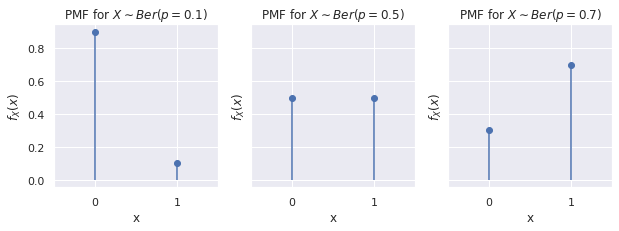

In [ ]:

fig, ax = plt.subplots(1,3,figsize=(10,3),sharey=True)
plot_disc(tfd.Bernoulli(probs=0.1),dname='Ber(p=0.1)',ax=ax[0])
plot_disc(tfd.Bernoulli(probs=0.5),dname='Ber(p=0.5)',ax=ax[1])
plot_disc(tfd.Bernoulli(probs=0.7),dname='Ber(p=0.7)',ax=ax[2])
plt.show()

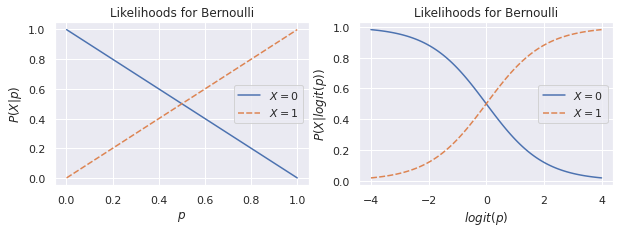

In [ ]:
fig, ax = plt.subplots(1,2,figsize=(10,3),sharey=False)
pi = np.linspace(0.001,0.999,100)
logiti = np.linspace(-4,4,100)
plot_lik(tfd.Bernoulli(probs=pi), [0,1], pi, dname='Bernoulli', pname='p',ax=ax[0])
plot_lik(tfd.Bernoulli(logits=logiti), [0,1], logiti, dname='Bernoulli', pname='logit(p)',ax=ax[1])



### Binomial Distribution

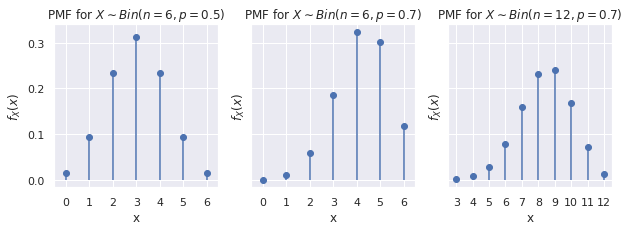

In [ ]:
fig, ax = plt.subplots(1,3,figsize=(10,3),sharey=True)
plot_disc(tfd.Binomial(6,probs=0.5),dname='Bin(n=6,p=0.5)',ax=ax[0])
plot_disc(tfd.Binomial(6,probs=0.7),dname='Bin(n=6,p=0.7)',ax=ax[1])
plot_disc(tfd.Binomial(12,probs=0.7),dname='Bin(n=12,p=0.7)',ax=ax[2])
plt.show()

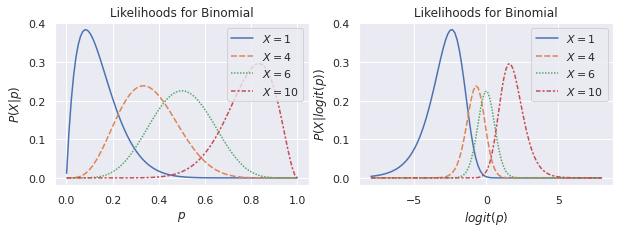

In [ ]:
fig, ax = plt.subplots(1,2,figsize=(10,3),sharey=False)
pi = np.linspace(0.001,0.999,100)
logiti = np.linspace(-8,8,100)
N = 12
X = [1,4,6,10]
plot_lik(tfd.Binomial(N,probs=pi), X, pi, dname='Binomial', pname='p',ax=ax[0])
plot_lik(tfd.Binomial(N,logits=logiti), X, logiti, dname='Binomial', pname='logit(p)',ax=ax[1])


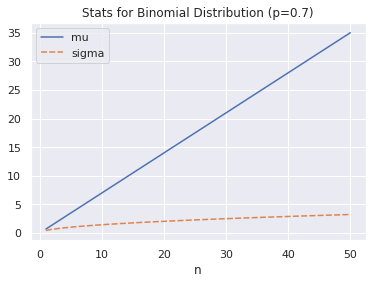

In [ ]:
### plot Mean & Variance of a Binomial as a function of n
n_vals = list(range(1,51))
rvs = tfd.Binomial(n_vals, probs=0.7)
mu = rvs.mean().numpy()
sig = rvs.stddev().numpy()
stats = pd.DataFrame({'mu':mu,'sigma':sig},index=n_vals)

ax = sns.lineplot(data=stats)
ax.set(title='Stats for Binomial Distribution (p=0.7)', xlabel='n')
plt.show()

#### Application of Binomial Distribution: 1-D Random Walk
We use the following transformation: 
$S_n = 2 Y_n -n $
where $Y_n \sim Bin(n,p)$ and $S_n$ is the position of a random walk after $n$ steps 

In [ ]:
def rw_1d_rv(n, probs):
    rw_1d = tfd.TransformedDistribution(
      distribution=tfd.Binomial(n,probs=probs),
      bijector=tfb.Chain([tfb.Shift(-n), tfb.Scale(2.)]),
      name='DiscreteRandomWalk1D')
    return rw_1d

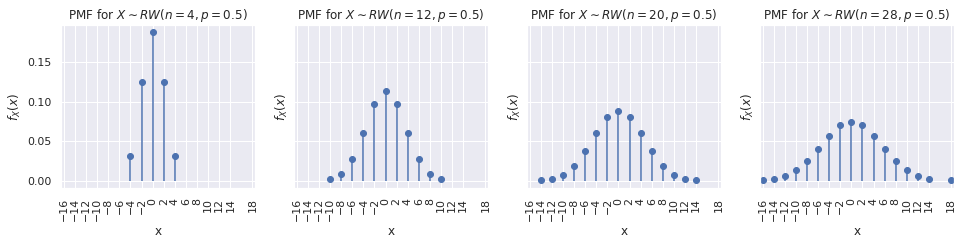

In [ ]:
## 1D Random Walk using Transformations.
fig, ax = plt.subplots( 1,4,figsize=(16,3),sharey=True,sharex=True)
for i,n in enumerate([4,12,20,28]):
  plot_disc(rw_1d_rv(n,probs=0.5),dname='RW(n={},p=0.5)'.format(n),ax=ax[i])
  ax[i].tick_params(axis='x', rotation=90)
plt.show()

##### What is the "spread" of the random walk with $n$ ?

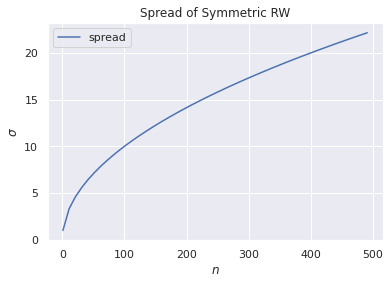

In [ ]:
n_vals = list(range(1,500,10))
sig=[]
for n in n_vals:
  rv = rw_1d_rv(n, probs=0.5)
  sig.append(rv.stddev().numpy())
stats = pd.DataFrame({'spread':sig},index=n_vals)
ax = sns.lineplot(data=stats)
ax.set(title='Spread of Symmetric RW', xlabel='$n$',ylabel='$\sigma$')
plt.show()

In [ ]:
n = pm.Normal.dist(mu=0, sigma=0.5)


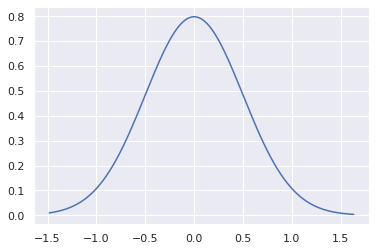

In [ ]:
plot_cont(n)

/usr/local/lib/python3.7/dist-packages/seaborn/distributions.py:2619: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


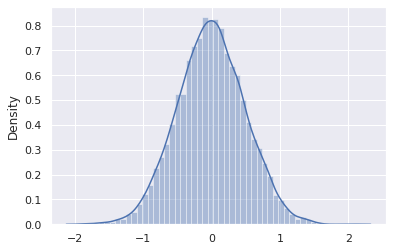

In [ ]:
samples = pm.draw(n,draws=10000)
sns.distplot(samples)

In [ ]:
with pm.Model() as nnmodel:
  n1 =  pm.Normal('n1',mu=0, sigma = 1)
  n2 =  pm.Normal('n2',mu=0, sigma = 0.5)
  ss =  pm.Deterministic('quot',n1 / (1+n2))
  ss2 =  pm.Deterministic('sq',n1*n1)
  ssn = n1 + n2
  trace = pm.sample()

Auto-assigning NUTS sampler...
INFO:pymc:Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
INFO:pymc:Initializing NUTS using jitter+adapt_diag...
Sequential sampling (2 chains in 1 job)
INFO:pymc:Sequential sampling (2 chains in 1 job)
NUTS: [n1, n2]
INFO:pymc:NUTS: [n1, n2]


Sampling 2 chains for 1_000 tune and 1_000 draw iterations (2_000 + 2_000 draws total) took 7 seconds.
INFO:pymc:Sampling 2 chains for 1_000 tune and 1_000 draw iterations (2_000 + 2_000 draws total) took 7 seconds.


array([[<matplotlib.axes._subplots.AxesSubplot object at 0x7f1a875c8ad0>,
      dtype=object)

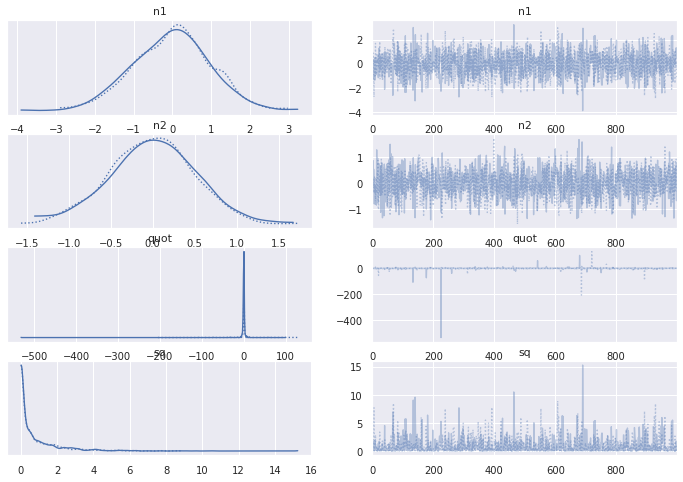

In [ ]:
pm.plot_trace(trace)

/usr/local/lib/python3.7/dist-packages/seaborn/distributions.py:2619: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


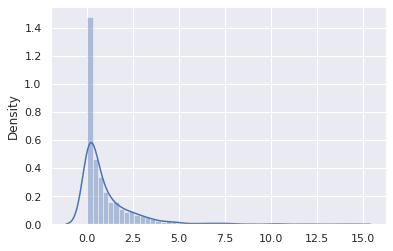

In [ ]:
samples = pm.draw(nnmodel.sq, draws=1000)
sns.distplot(samples)

In [ ]:
pm.summary(trace)

,mean,sd,hdi_3%,hdi_97%,mcse_mean,mcse_sd,ess_bulk,ess_tail,r_hat
n1,-0.019,0.981,-1.799,1.835,0.023,0.021,"1,890.000","1,511.000",1.000
n2,-0.008,0.505,-0.998,0.908,0.011,0.012,"1,954.000","1,343.000",1.000
quot,-0.489,14.177,-3.689,3.966,0.314,0.224,"1,809.000","1,446.000",1.000
sq,0.962,1.368,0.000,3.339,0.042,0.029,"1,112.000","1,188.000",1.000


In [ ]:
with pm.Model():
  nn = pm.Normal('x',mu=0, sigma=1)

In [ ]:
nn.eval()

array(-1.34162535)

/usr/local/lib/python3.7/dist-packages/seaborn/distributions.py:2619: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)
/usr/local/lib/python3.7/dist-packages/seaborn/distributions.py:316: UserWarning: Dataset has 0 variance; skipping density estimate. Pass `warn_singular=False` to disable this warning.
  warnings.warn(msg, UserWarning)


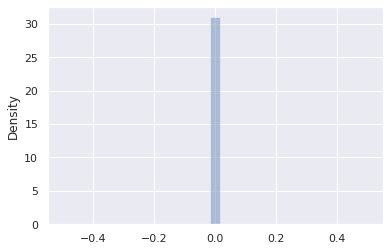

In [ ]:
import aesara.tensor as at
ss = [at.clip(nn,0,np.inf).eval() for _ in range(1000)]
sns.distplot(np.asarray(ss))

In [ ]:
pm.logp(n,4).eval()

array(-8.91893853)

In [ ]:
pm.draw(n, draws=10)

array([ 0.29862221,  0.22625645, -1.24188568, -1.16451608,  0.42023464,
       -0.65957527, -1.42638634, -3.06755187,  0.73050851,  0.02138875])

Value of z = [-1.95062383 -0.78221638 -1.75114165]
Value of z = [-1.95062383 -0.78221638 -1.75114165]
Value of z = [-1.95062383 -0.78221638 -1.75114165]
Value of z = [-1.95062383 -0.78221638 -1.75114165]
Value of z = [-1.95062383 -0.78221638 -1.75114165]


In [ ]:
%env MKL_THREADING_LAYER=GNU
RANDOM_SEED = 8927
rng = np.random.default_rng(RANDOM_SEED)
import pymc3 as pm3

env: MKL_THREADING_LAYER=GNU


In [ ]:
n = pm3.Normal.dist(mu=0, sigma=0.5)

In [ ]:
n.random(size=[10,1])

array([[ 0.24452977],
       [ 0.40180255],
       [-0.22303993],
       [-0.47563036],
       [-0.46105032],
       [ 0.6189624 ],
       [-0.63817855],
       [-0.07051711],
       [-0.12005459],
       [-0.10143964]])

In [ ]:
with pm3.Model() as nnmodel:
  n1 =  pm3.Normal('n1',mu=0, sd = 1)
  n2 =  pm3.Normal('n2',mu=0, sd = 0.5)
  ss =  pm3.Deterministic('sum',n1 + n2)
  ssn = n1 + n2
  trace = pm3.sample(10)

/usr/local/lib/python3.7/dist-packages/deprecat/classic.py:215: FutureWarning: In v4.0, pm.sample will return an `arviz.InferenceData` object instead of a `MultiTrace` by default. You can pass return_inferencedata=True or return_inferencedata=False to be safe and silence this warning.
  return wrapped_(*args_, **kwargs_)
Only 10 samples in chain.
Auto-assigning NUTS sampler...
INFO:pymc3:Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
INFO:pymc3:Initializing NUTS using jitter+adapt_diag...
Sequential sampling (2 chains in 1 job)
INFO:pymc3:Sequential sampling (2 chains in 1 job)
NUTS: [n2, n1]
INFO:pymc3:NUTS: [n2, n1]


Sampling 2 chains for 1_000 tune and 10 draw iterations (2_000 + 20 draws total) took 2 seconds.
INFO:pymc3:Sampling 2 chains for 1_000 tune and 10 draw iterations (2_000 + 20 draws total) took 2 seconds.


ValueError: ignored

AttributeError: ignored

In [ ]:
sn = n + n2

TypeError: ignored

### Example - Distribution of Sum of n Dice
Let $X_n$ be the sum of $n$ six-faced symmetric dice rolls. If $f_{X_n}$ is the PMF of $X_n$ we use the recursion relation:

$f_{X_n}(x) = \frac{1}{6}\sum_{k=1}^{6}f_{X_{n-1}}(x-k)$

where $f_{X_n}(x) = 0$ for $x < n$ and $x > 6n$.

In [ ]:
from functools import lru_cache
@lru_cache(maxsize = 100)
def f_DiceSum(n, x):

  if x < n or x > 6*n:
    return 0
  if n == 1:
    return 1./6
  return (1./6)*sum([f_DiceSum(n-1,x-k) for k in range(1,7)])

In [ ]:
def compute_and_plot_dice_sum(n):
  distro = [(k,f_DiceSum(n,k)) for k in range(n,6*n+1)]
  df = pd.DataFrame(distro,columns=['x','$f_X(x)$'])
  sns.barplot(x='x',y='$f_X(x)$',data=df).set_title('Distribution $f_{X_n}$ of sum $X_n$ of $n$ Dice, for n='+str(n))
  plt.show()
  return distro


def compute_and_plot_cumulative_dice_sum(n):
  distro = [(k,f_DiceSum(n,k)) for k in range(n,6*n+1)]
  x, pmf = list(zip(*distro))
  cumdistro  = zip(x,[sum(pmf[:(j+1)]) for j in range(len(pmf))])
  df = pd.DataFrame(cumdistro,columns=['x','$F_X(x)$'])
  sns.barplot(x='x',y='$F_X(x)$',data=df).set_title('Cumulative $F_{X_n}$ of sum $X_n$ of $n$ Dice, for n='+str(n))
  plt.show()

def compute_summary_stats(distro):
  stats = {}
  x, pmf = list(zip(*distro))
 # cumdistro  = zip(x,[sum(pmf[:(j+1)]) for j in range(len(pmf))])
  x = np.asarray(x)
  pmf = np.asarray(pmf)
  stats['mean'] = round(sum(x*pmf),3)
  stats['mode'] = [round(v,3) for v in x[np.where(pmf == np.max(pmf))[0]].tolist()]
  stats['median'] = round(x[np.where(np.cumsum(pmf)>=0.5)[0][0]],3)
  p25 = x[np.where(np.cumsum(pmf)>=0.25)[0][0]]
  p50 = x[np.where(np.cumsum(pmf)>=0.75)[0][0]]
  stats['var'] = round(sum(((x-stats['mean'])**2)*pmf),3)
  stats['std'] = round(np.sqrt(stats['var']),3)
  stats['IQR'] = round(p50 - p25,3)
  stats['MAD'] = round(sum(np.abs(x-stats['median'])*pmf),3)
  return pd.DataFrame.from_dict(stats, orient='index')



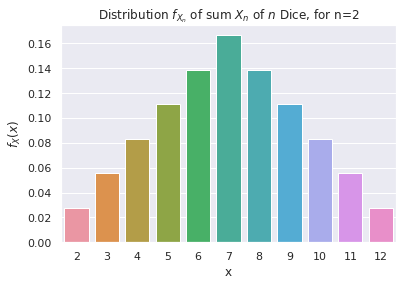

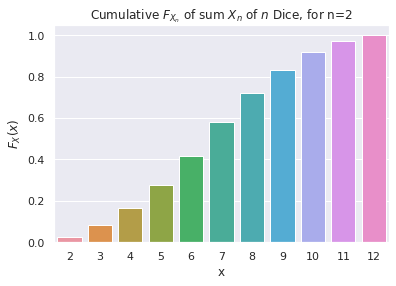

In [ ]:
s_2 = compute_and_plot_dice_sum(2)
compute_and_plot_cumulative_dice_sum(2)

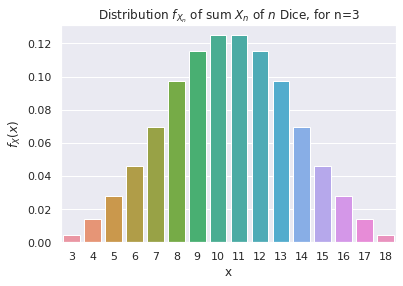

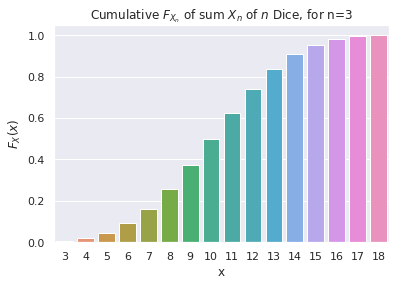

In [ ]:
s_3 = compute_and_plot_dice_sum(3)
compute_and_plot_cumulative_dice_sum(3)

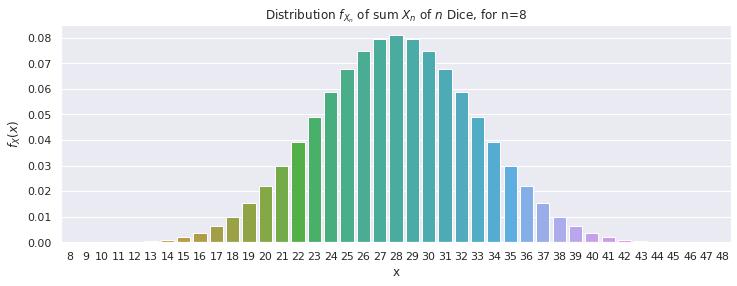

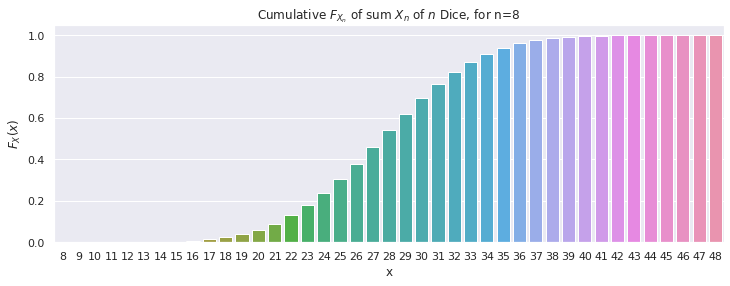

In [ ]:
plt.figure(figsize=(12,4))
s_8 = compute_and_plot_dice_sum(8)
plt.figure(figsize=(12,4))
compute_and_plot_cumulative_dice_sum(8)

In [ ]:
### Show stats
stats = pd.concat((compute_summary_stats(s_2),
                   compute_summary_stats(s_3),
                   compute_summary_stats(s_8)), axis=1)
stats.columns=['n=2','n=2','n=8']
display(stats)

,n=2,n=2,n=8
mean,7.000,10.500,28.000
mode,[7],[10],[28]
median,7,11,28
var,5.833,8.750,23.333
std,2.415,2.958,4.830
IQR,4,5,6
MAD,1.944,2.417,3.867


#### Average of digits in the n-Dice throw example.
Instead of sum, Let $Y_n$ be the average of $n$ six-faced symmetric dice rolls. Then $Y_n = \frac{1}{n} X_n$. Lets compute and plot the distribution of $Y_n$ for various values of $n$, and this time also compute the mean, median, mode, variance and standard deviations.

In [ ]:
def compute_and_plot_dice_average(n):
  distro = [(k/n,f_DiceSum(n,k)) for k in range(n,6*n+1)]
  df = pd.DataFrame(distro,columns=['y','$f_Y(y)$'])
  ax = sns.barplot(x='y',y='$f_Y(y)$',data=df)
  ax.set_title('Distribution $f_{Y_n}$ of average of digits, $Y_n$ of $n$ Dice, for n='+str(n))
  t = ax.get_xticks()
  l = ax.get_xticklabels()
  ax.set_xticks([0,int(len(t)/2),len(t)-1])
  ax.set_xticklabels([l[0],l[int(len(t)/2)],l[-1]])
  plt.tight_layout()
  plt.show()
  return distro



  

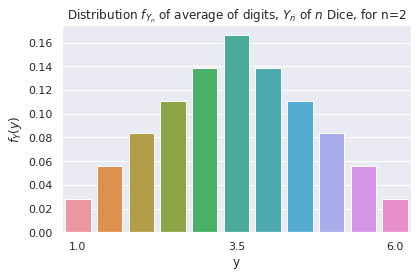

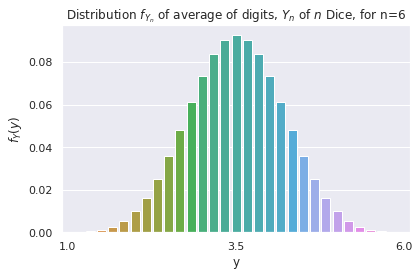

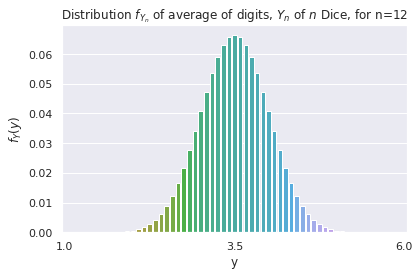

--------------------
    Stats for Y_n
--------------------


,n=2,n=6,n=12
mean,3.500,3.500,3.500
mode,[3.5],[3.5],[3.5]
median,3.500,3.500,3.500
var,1.458,0.486,0.243
std,1.207,0.697,0.493
IQR,2.000,1.000,0.667
MAD,0.972,0.559,0.394


In [ ]:
d_2 = compute_and_plot_dice_average(2)
d_6 = compute_and_plot_dice_average(6)
d_12 = compute_and_plot_dice_average(12)

print('--------------------')
print('    Stats for Y_n')
print('--------------------')
stats = pd.concat((compute_summary_stats(d_2),
                   compute_summary_stats(d_6),
                   compute_summary_stats(d_12)), axis=1)
stats.columns=['n=2','n=6','n=12']
display(stats)

## Example D3. Dart Throw Example.
We simulate the dart throw example, where the dart radius is 1 ft, by generating random points in a square of 2ft x 2ft, discarding all values that fall outside of the circle since we assume it always lands in the circle.. We want to th calculate the probability that the dart lands within R ft of the center.

In [ ]:
from collections import Counter

In [ ]:
def dart_position(radius=1.):
    """
    Simulate the random throw of a dart. Note that if it lands outside the circle, we discard it.
    Return the distance of landed dart from the center.
    """
    ## choose random point in square around circle
    x = radius*(-1+2*random.random())
    y = radius*(-1+2*random.random())
    ## repeat till get something inside
    if x**2 + y**2 > radius**2 :
      return dart_position(radius)
    return np.sqrt(x**2 + y**2)


In [ ]:
### Now use simulation to calculated CDF of the 
## i.e. Pr(dart_position <= R)

NUM_THROWS = 100000
dart_cnts = Counter()

for R in np.linspace(0,1.0,101):
  num_hits = 0
  for i in range(NUM_THROWS):
    if dart_position() <= R:
      num_hits += 1
  dart_cnts[R] += num_hits

## convert counts to probabilities
dart_cdf = pd.DataFrame([(R,cnt/NUM_THROWS) for R,cnt in dart_cnts.items()], columns=['R','CDF'])

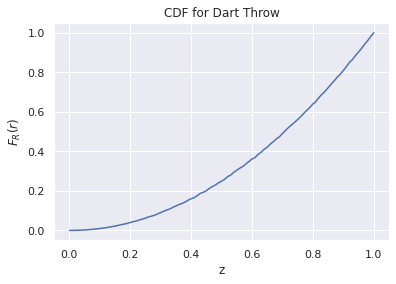

In [ ]:
#dart_cdf_df = pd.DataFrame.from_dict(dart_cdf,orient='index',columns=['R','CDF_R'])
sns.lineplot(data=dart_cdf, x='R',y='CDF').set(xlabel='z',ylabel='$F_R(r)$',title='CDF for Dart Throw')
plt.show()

#### Interesting Application of Dart Probability Problem.
An interesting application of the dart probability problem is as follows. Given that a dart lands in a square dart of side length 1, what is the probability that the dart lands inside a circle of radius $\frac{1}{2}$ inscribed in the square? The answer is $\frac{\pi}{4}$ 

In [ ]:
NUM_THROWS = 100000
in_circle = 0
for _ in range(NUM_THROWS):
  ## get random dart position, assume square of side 1.0 and centered at (0,0)
  x,y = random.random() - 0.5, random.random() - 0.5
  if x**2 + y**2 <= 0.5*0.5: ## inside circle of radius 0.5
    in_circle += 1
print('4*Probability dart lands in circle = {:.05f}'.format(4.*in_circle/NUM_THROWS))

4*Probability dart lands in circle = 3.13740


## Example D5. Function of a Random Variable.
We will use the CDF for $R$, the distance of the dart from the center, calculated above to plot the corresponding CDF of $Z = \pi R^2$. Since we are using a discrete approximation of the original distribution, this simply means changing the x-axis of the plot to the transformed value.  

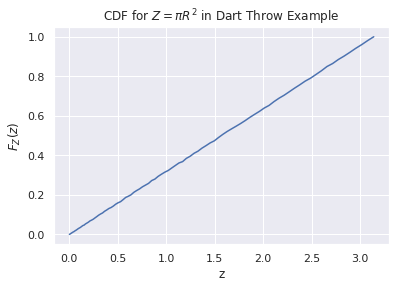

In [ ]:
dart_cdf['Z'] = dart_cdf.R.map(lambda x: np.pi*x*x)
sns.lineplot(data=dart_cdf, x='Z',y='CDF').set(xlabel='z',ylabel='$F_Z(z)$',title='CDF for $Z=\pi R^2$ in Dart Throw Example')
plt.show()

### Example - Transformations of two variables using Simulation
$X,Y$ are two randomly thrown dart positions (distance from center). What is the distribution of $Z=\frac{X}{Y}$ ?

#### Simulation Procedure
In the previous example, we c way to calculate CDF was fairly ineffcient since for each $r$ we calculated $F_R(r)$ by simulating the throws and discarding values above $r$. In this simulation procedure, we will instead directly generate data points, and then bin them to compute the CDF. 
Binning can be done directly, or we can just use the builtin `sns.kdeplot` or `plt.hist` methods.

In [ ]:
## simulate data
NUM_THROWS = 10000
ratio_dat = []
for _ in range(NUM_THROWS):
   X = dart_position()
   Y = dart_position()
   ratio_dat.append(X/Y)

In [ ]:
### Compute CDF directly from list of simulated data
def get_cdf(X, data):
  return [sum(x>np.asarray(ratio_dat))/len(data) for x in X]

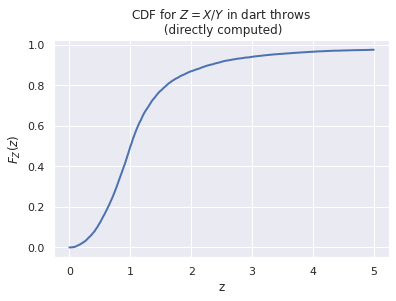

In [ ]:
Z = np.linspace(0,5.,1000)
ratio_cdf = pd.DataFrame([(z,p) for z,p in zip(Z,get_cdf(Z, ratio_dat))], columns=['Z','CDF'])

plt.figure(figsize=(6,4))
sns.lineplot(data=ratio_cdf, x='Z',y='CDF',linewidth=2).set(xlabel='z',ylabel='$F_Z(z)$',
                                                title='CDF for $Z=X/Y$ in dart throws\n (directly computed)')
                                             
plt.show() 

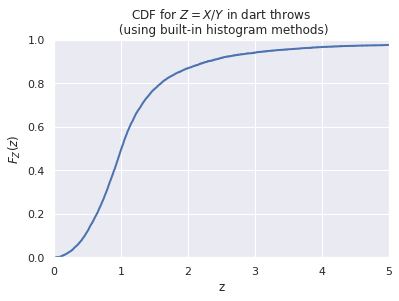

In [ ]:
### CDF Using built-in histogram methods
plt.figure(figsize=(6,4))
ax = sns.ecdfplot(ratio_dat, linewidth=2)
ax.set_xlim(0,5)
ax.set( xlim=(0,5), xlabel='z',ylabel='$F_Z(z)$', 
       title='CDF for $Z=X/Y$ in dart throws\n (using built-in histogram methods)' )
plt.show()


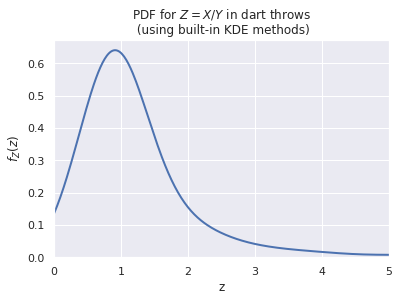

In [ ]:
### PDF Using built-in histogram (kdeplot) methods
plt.figure(figsize=(6,4))
ax = sns.kdeplot(ratio_dat,gridsize=10000, linewidth=2, )
ax.set_xlim(0,5)
ax.set( xlim=(0,5), xlabel='z',ylabel='$f_Z(z)$', 
       title='PDF for $Z=X/Y$ in dart throws\n (using built-in KDE methods)')
plt.show()


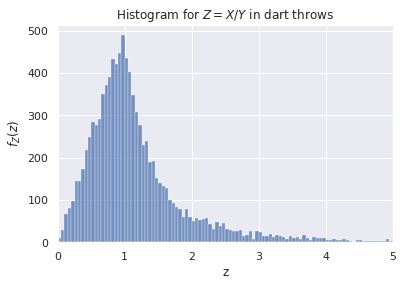

In [ ]:
### PDF visualization using histogram
plt.figure(figsize=(6,4))
ax = sns.histplot(ratio_dat,binrange=(0,5),bins=100)
ax.set( xlim=(0,5), xlabel='z',ylabel='$f_Z(z)$', 
       title='Histogram for $Z=X/Y$ in dart throws')
plt.show()


In [ ]:
np.sqrt(0.25), np.sqrt(0.5), np.sqrt(0.75)

(0.5, 0.7071067811865476, 0.8660254037844386)

## Example D?. Expected Value of Distribution Using Simulation
We revisit the dart problem, and calculate the expected value of dart position $R$ as the long-running average of samples. Using direct integration we found that $E[R] = \frac{2}{3}$, and variance $V[R] = \frac{1}{18}$. Also, for  $100p$'th percentile value $x_p = p^{\frac{1}{2}}$. These values are, respectively, for $p=\frac{1}{4}, \frac{1}{2}, \frac{3}{4}$ as $\frac{1}{2}, \frac{1}{\sqrt{2}}$ and $\frac{\sqrt{3}}{2}$.

In [ ]:
NUM_THROWS = 50000
dart_dat = [dart_position() for _ in range(NUM_THROWS)]
E_R = np.mean(dart_dat)
print('E[R]     = {:.03f}'.format(E_R))
V_R = np.var(dart_dat)
print('V[R]     = {:.03f}'.format(V_R))
p_25 = np.percentile(dart_dat, 25)
print('P_25[R]  = {:.03f}'.format(p_25))
med_R = np.median(dart_dat)
print('Med[R]   = {:.03f}'.format(med_R))
p_75 = np.percentile(dart_dat, 75)
print('P_75[R]  = {:.03f}'.format(p_75))


# We can also just use pandas to compute these at once.
## all summary statistics
summ = pd.DataFrame(dart_dat,columns=['R']).describe()
display(summ)

E[R]     = 0.667
V[R]     = 0.056
P_25[R]  = 0.499
Med[R]   = 0.707
P_75[R]  = 0.867


,R
count,"50,000.000"
mean,0.667
std,0.236
min,0.003
25%,0.499
50%,0.707
75%,0.867
max,1.000
